CNN신경망

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [8]:
## 공식 코드
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    ) # nn.Conv2 함수에 대한 인자를 모두 규정해 주는 듯

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [9]:
# 기본 블럭. resnet32 까지 사용
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

NameError: name 'Optional' is not defined

In [ ]:
# Resnet50 부터는 보틀넥 구조 사용
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> ResNet: # 리턴 타입이 ResNet 객체라는 것을 명시
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model
    # 결국 이 아래의 함수들은 모듈화를 위한 함수들인 것. 최종 리턴은 ResNet 객체

_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

class ResNet50_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet50-0676ba61.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 25557032,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 76.130,
                    "acc@5": 92.862,
                }
            },
            "_ops": 4.089,
            "_file_size": 97.781,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet50-11ad3fa6.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 25557032,
            "recipe": "https://github.com/pytorch/vision/issues/3995#issuecomment-1013906621",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 80.858,
                    "acc@5": 95.434,
                }
            },
            "_ops": 4.089,
            "_file_size": 97.79,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2

In [ ]:
# resnet50 을 불러온다고 가정했을 때, "return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)"을 리턴한다.
@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet50_Weights.IMAGENET1K_V1))
def resnet50(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    """ResNet-50 from `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`__.

    .. note::
       The bottleneck of TorchVision places the stride for downsampling to the second 3x3
       convolution while the original paper places it to the first 1x1 convolution.
       This variant improves the accuracy and is known as `ResNet V1.5
       <https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch>`_.

    Args:
        weights (:class:`~torchvision.models.ResNet50_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.ResNet50_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.ResNet50_Weights
        :members:
    """
    weights = ResNet50_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


In [7]:
batch_size = 256*2
learning_rate = 0.0002
num_epoch = 30

In [ ]:
CIFAR10_train=dset.CIFAR10("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
CIFAR10_test=dset.CIFAR10("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

NameError: name 'dset' is not defined

In [ ]:
train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
test_loader = DataLoader(CIFAR10_test, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=VGG16(num_classes=100, base_dim=32).to(device=device)
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
loss_array = []

In [ ]:
optimizer=optim.Adam(model.parameters(), lr=learning_rate/50)
for i in range(num_epoch):
    print("epoch", i, "is start")
    for j, [img, label] in enumerate(train_loader):
        x = img.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output= model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            loss_array.append(loss.cpu().detach().numpy())
    print(loss)

epoch 0 is start
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 1 is start
tensor(1.0734e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 2 is start
tensor(5.0426e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 3 is start
tensor(4.1279e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 4 is start
tensor(4.4722e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 5 is start
tensor(1.1446e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 6 is start
tensor(2.2774e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 7 is start


KeyboardInterrupt: 

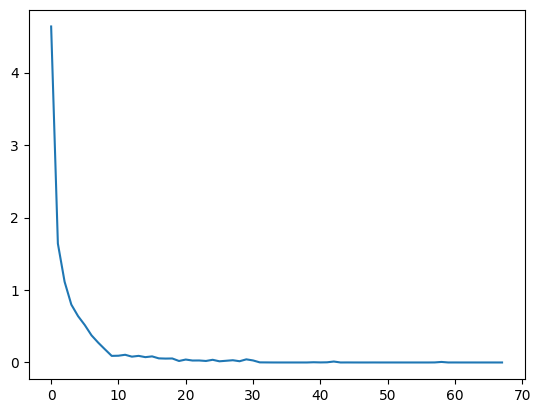

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_array[:])
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        x = img.to(device)
        y_ = label.to(device)

        output = model.forward(x)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 76.171875
